In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import time
from os import listdir
from os.path import isfile, join

import pprint
import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageColor, ImageFont

import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks
plt.rcParams["savefig.bbox"] = 'tight'

plt.style.use('seaborn-white')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Helper function for showing images

In [25]:
def show(imgs, num_cols=2):
    num_imgs = len(imgs)
    num_rows = int(num_imgs / num_cols)
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=num_cols, nrows=num_rows, 
                            figsize=(10, 6 / num_cols * num_rows))
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = img.detach()
            img = F.to_pil_image(img)
        row, col = i // num_cols, i % num_cols
        if isinstance(axs, matplotlib.axes.Axes):
            axs.imshow(np.asarray(img))
            axs.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        elif axs.ndim == 1:
            axs[col].imshow(np.asarray(img))
            axs[col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        else:
            axs[row, col].imshow(np.asarray(img))
            axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# BDD100K

- Only have semantic segmentation label for 10K images, not the videos. One labeled frame per video.
- All traffic signs are grouped together as one class and include non-standard road signs.
- Has panoptic segmentation if needed (instance + semantic segmentation).

Plotting images and label the desired object.

In [ ]:
data_dir = '/home/chawin/data/bdd100k/'
img_path = join(data_dir, 'images/10k/train/')
label_path = join(data_dir, 'labels/sem_seg/masks/train/')
label = 7       # Set to class of the object to show

filenames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
np.random.shuffle(filenames)

images = []
for i, filename in enumerate(filenames):
    img = read_image(join(img_path, filename))
    mask = read_image(join(label_path, filename.split('.')[0] + '.png', ))
    if (mask == label).any():
        img = draw_segmentation_masks(img, masks=mask == label, alpha=.6, colors=(60, 255, 0))
        images.append(img)
        print(f'Number of object pixels: {(mask == label).int().sum().item():d}')
    if len(images) == 8:
        break
show(images)

In [ ]:
print('Image size: ', img.shape)

## Cityscapes

- 2975 training images and 500 validation images with segmentation labels (semantic and panoptic).
- Each labeled frame comes from a different video sequence.
- Use broad category of `traffic signs` which include all kinds of traffic signs, direction signs, and non-standard signs. See https://www.cityscapes-dataset.com/examples/#fine-annotations.

In [ ]:
import sys
sys.path.append('/home/chawin/adv-patch-bench/datasets/panoptic_parts/')

import panoptic_parts as pp

In [ ]:
data_dir = '/home/chawin/data/cityscapes/'
img_path = join(data_dir, 'leftImg8bit/train/aachen/')
label_path = join(data_dir, 'gtFinePanopticParts/train/aachen/')
label = 7       # Set to class of the object to show

filenames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
np.random.shuffle(filenames)

images = []
for i, filename in enumerate(filenames):
    img = Image.open(join(img_path, filename))
    img = np.array(img)
    maskname = filename.replace('leftImg8bit.png', 'gtFinePanopticParts.tif')
    mask = Image.open(join(label_path, maskname))
    mask = np.array(mask)
    # Split uid into tuple of sid, iid, and pid
    sid_iid_pid = pp.decode_uids(mask)
    colors = pp.uid2color(sid_iid_pid)
    break
#     mask = read_image(join(label_path, filename.split('.')[0] + '.png', ))
#     if (mask == label).any():
#         img = draw_segmentation_masks(img, masks=mask == label, alpha=.6, colors=(60, 255, 0))
#         images.append(img)
#         print(f'Number of object pixels: {(mask == label).int().sum().item():d}')
#     if len(images) == 8:
#         break
# show(images)

In [ ]:
plt.imshow(mask)

## COCO

- See https://cocodataset.org/#explore. 
- Has a separate class for `stop signs` but does not have any other signs.
- Not a driving dataset. No video data.

## WildDash 2

- See https://wilddash.cc/download.
- 4256 input images with panoptic, instance and semantic segmentation ground truth.
- Similar labels to Cityscapes, i.e. all traffic signs are grouped together as `traffic sign` class.
- Has a separate class for `billboard`.

## Mapillary Vistas Dataset

- See https://www.mapillary.com/dataset/vistas. To see label definition, visit this [link](https://openaccess.thecvf.com/content_ICCV_2017/supplemental/Neuhold_The_Mapillary_Vistas_ICCV_2017_supplemental.pdf).
- Street images: 25,000 high-resolution images, 124 semantic object categories.
- Has `traffic sign` class with `front` and `back` separated.
- Has `billboard` class.
- Has `traffic-signframe` class: "Frame construction holding large signs, where frame can be made of round or square poles. Can be typically found on highways."
- Creative Commons Attribution NonCommercial Share Alike (CC BY-NC-SA) license.

## Mapillary Traffic Sign Dataset

- See https://www.mapillary.com/dataset/trafficsign.
- 100,000 high-resolution images (52,000 fully annotated, 48,000 partially annotated)
- Over 300 traffic sign classes with bounding box annotations

In [4]:
def load_annotation(label_path, image_key):
    with open(join(label_path, '{:s}.json'.format(image_key)), 'r') as fid:
        anno = json.load(fid)
    return anno

Falling back to default font...


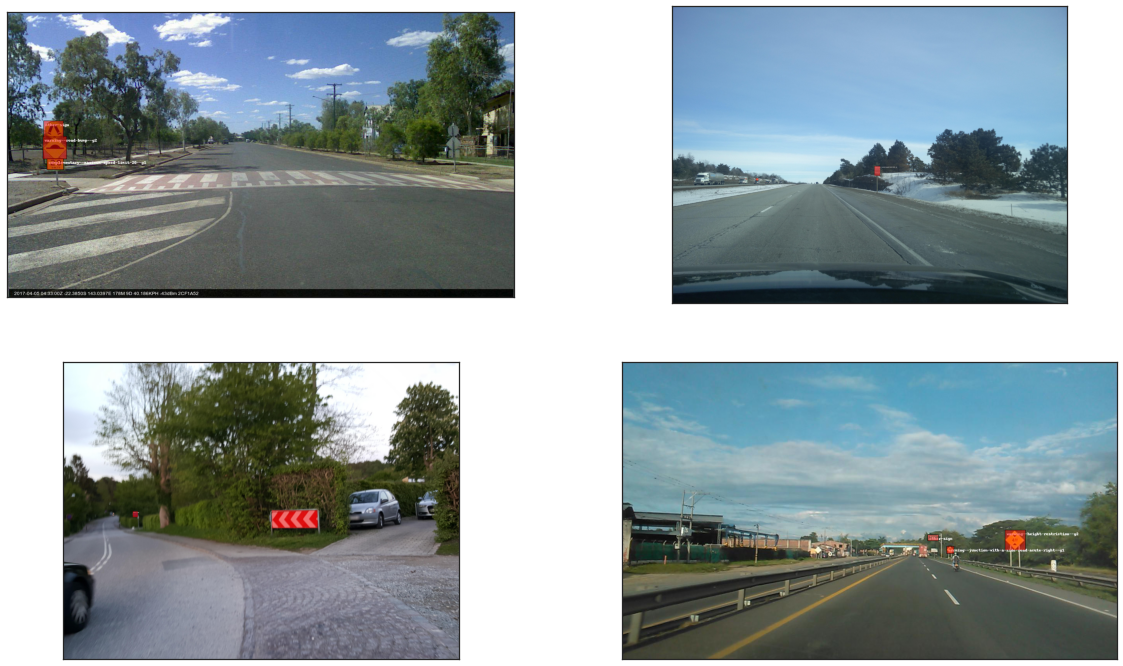

In [5]:
data_dir = '/data/shared/mtsd_v2_fully_annotated/'
img_path = join(data_dir, 'train')
label_path = join(data_dir, 'annotations')

filenames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
np.random.shuffle(filenames)

color = 'red'
alpha = 125
try:
    font = ImageFont.truetype('arial.ttf', 15)
except:
    print('Falling back to default font...')
    font = ImageFont.load_default()

images = []
for i, filename in enumerate(filenames):
    img = Image.open(join(img_path, filename))
#     img = np.array(img)
#     bbox = load_annotation(label_path, filenames.split('.')[0])['objects']['bbox']
#     x1, y1 = bbox['xmin'], bbox['ymin']
#     x2, y2 = bbox['xmax'], bbox['ymax']
    anno = load_annotation(label_path, filename.split('.')[0])
    
    img = img.convert('RGBA')
    img_draw = ImageDraw.Draw(img)

    rects = Image.new('RGBA', img.size)
    rects_draw = ImageDraw.Draw(rects)

    for obj in anno['objects']:
        x1 = obj['bbox']['xmin']
        y1 = obj['bbox']['ymin']
        x2 = obj['bbox']['xmax']
        y2 = obj['bbox']['ymax']

        color_tuple = ImageColor.getrgb(color)
        if len(color_tuple) == 3:
            color_tuple = color_tuple + (alpha,)
        else:
            color_tuple[-1] = alpha

        rects_draw.rectangle((x1+1, y1+1, x2-1, y2-1), fill=color_tuple)
        img_draw.line(((x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)), fill='black', width=1)

        class_name = obj['label']
        img_draw.text((x1 + 5, y1 + 5), class_name, font=font)

    img = Image.alpha_composite(img, rects)
    images.append(img)
    if len(images) == 4:
        break

show(images)

In [5]:
data_dir = '/data/shared/mtsd_v2_fully_annotated/'
img_path = join(data_dir, 'train')
label_path = join(data_dir, 'annotations')

filenames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
np.random.shuffle(filenames)
images, labels = [], []

start = time.time()
for i, filename in enumerate(filenames):
    img = Image.open(join(img_path, filename))
    img = np.array(img)
    anno = load_annotation(label_path, filename.split('.')[0])

    for obj in anno['objects']:
        x1 = int(obj['bbox']['xmin'])
        y1 = int(obj['bbox']['ymin'])
        x2 = int(obj['bbox']['xmax'])
        y2 = int(obj['bbox']['ymax'])
        if not obj['properties']['ambiguous']:
            images.append(img[y1:y2, x1:x2])
            labels.append(obj['label'])
    
    print(i)
    if len(labels) > 5000:
        break
# print(time.time() - start)
# show(images[:10], num_cols=10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
print('Example of the annotation')
anno

Example of the annotation


{'width': 3264,
 'height': 2448,
 'ispano': False,
 'objects': [{'key': '8655b3ay8i3vm2eyabnau9',
   'label': 'warning--crossroads-with-priority-to-the-right--g1',
   'bbox': {'xmin': 2220.890625,
    'ymin': 914.4140625,
    'xmax': 2275.078125,
    'ymax': 961.03125},
   'properties': {'barrier': False,
    'occluded': False,
    'out-of-frame': False,
    'exterior': False,
    'ambiguous': False,
    'included': False,
    'direction-or-information': False,
    'highway': False,
    'dummy': False}},
  {'key': 'sz926487mcdcthizywenml',
   'label': 'information--pedestrians-crossing--g1',
   'bbox': {'xmin': 1012.828125,
    'ymin': 1071.59765625,
    'xmax': 1047.890625,
    'ymax': 1111.640625},
   'properties': {'barrier': False,
    'occluded': False,
    'out-of-frame': False,
    'exterior': False,
    'ambiguous': False,
    'included': False,
    'direction-or-information': False,
    'highway': False,
    'dummy': False}},
  {'key': '75h8s17y3vitfxb2cc7kuo',
   'label': 're

Num traffic signs: 5005
Num classes: 331
Top-20 classes: ['other-sign' 'information--pedestrians-crossing--g1'
 'regulatory--yield--g1' 'regulatory--no-entry--g1'
 'information--parking--g1' 'complementary--chevron-left--g1'
 'warning--pedestrians-crossing--g4' 'regulatory--no-parking--g1'
 'regulatory--keep-right--g1' 'regulatory--no-stopping--g15'
 'complementary--chevron-right--g1' 'regulatory--stop--g1'
 'regulatory--priority-road--g4' 'regulatory--maximum-speed-limit-40--g1'
 'regulatory--maximum-speed-limit-30--g1' 'regulatory--keep-right--g4'
 'warning--curve-left--g2' 'regulatory--maximum-speed-limit-60--g1'
 'regulatory--no-parking--g2' 'regulatory--maximum-speed-limit-50--g1']


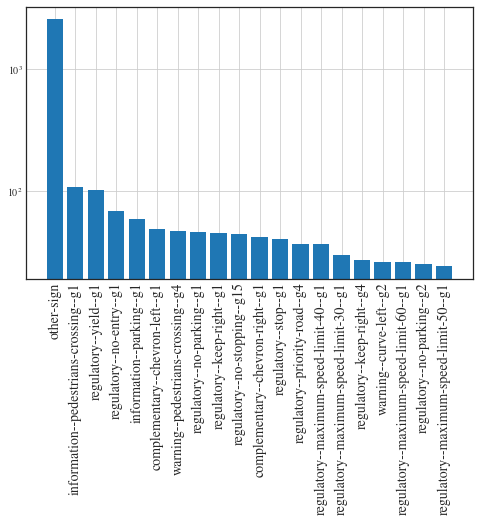

In [7]:
k = 20
print(f'Num traffic signs: {len(images)}')

idx_to_label, label_counts = np.unique(labels, return_counts=True)
print(f'Num classes: {len(idx_to_label)}')

top_idx = np.argsort(label_counts)[::-1][:k]
top_labels = idx_to_label[top_idx]
print(f'Top-{k} classes: {top_labels}')

plt.figure(figsize=(8, 5))
plt.bar(np.arange(k), label_counts[top_idx])
ax = plt.gca()
ax.set_xticks(np.arange(k))
ax.set_xticklabels(top_labels, rotation=90, fontsize=14)
plt.yscale('log')
plt.grid(True)
plt.show()

# image_array = np.array(images)
# label_array = 
# for i in range(k):
#     idx_filter = np.array([l == top_labels[i] for l in labels])
    
# is_in_topk = np.array([l in top_labels for l in labels])
# idx = np.array([for l in labels])

In [43]:
len(idx_to_label)

331

In [35]:
def show_specific_label(images, label, num=10):
    idx_filter = np.nonzero([l == label for l in labels])[0][:num]
    if len(idx_filter) == 0:
        print('Given label does not exist!')
        return
    num = min(len(idx_filter), num)
#     print(num)
    lb_images = []
    for j in idx_filter:
        lb_images.append(images[j])
    show(lb_images, num_cols=num)

In [40]:
[label for label in idx_to_label if 'complementary' in label]

['complementary--both-directions--g1',
 'complementary--chevron-left--g1',
 'complementary--chevron-left--g2',
 'complementary--chevron-left--g3',
 'complementary--chevron-left--g4',
 'complementary--chevron-left--g5',
 'complementary--chevron-right--g1',
 'complementary--chevron-right--g3',
 'complementary--chevron-right--g4',
 'complementary--chevron-right--g5',
 'complementary--chevron-right-unsure--g6',
 'complementary--distance--g1',
 'complementary--distance--g2',
 'complementary--distance--g3',
 'complementary--except-bicycles--g1',
 'complementary--extent-of-prohibition-area-both-direction--g1',
 'complementary--go-left--g1',
 'complementary--go-right--g1',
 'complementary--go-right--g2',
 'complementary--keep-left--g1',
 'complementary--keep-right--g1',
 'complementary--maximum-speed-limit-15--g1',
 'complementary--maximum-speed-limit-20--g1',
 'complementary--maximum-speed-limit-25--g1',
 'complementary--maximum-speed-limit-30--g1',
 'complementary--maximum-speed-limit-35--g1

In [ ]:
for label in idx_to_label:
    if 'information' in label:
        show_specific_label(images, label)
        plt.title(label)
        plt.show()

In [13]:
images = list(images)

other-sign
information--pedestrians-crossing--g1
complementary--chevron-right--g1
regulatory--yield--g1
regulatory--no-entry--g1
regulatory--priority-road--g4
complementary--chevron-left--g1
regulatory--no-stopping--g15
information--parking--g1
regulatory--stop--g1
regulatory--keep-right--g1
regulatory--no-parking--g1
regulatory--no-heavy-goods-vehicles--g2
regulatory--keep-right--g4
regulatory--maximum-speed-limit-50--g1
regulatory--maximum-speed-limit-30--g1
regulatory--maximum-speed-limit-40--g1
warning--pedestrians-crossing--g4
warning--curve-left--g2
warning--traffic-signals--g3


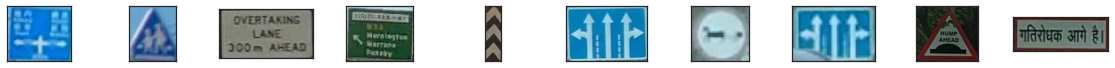

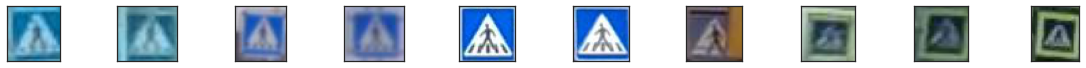

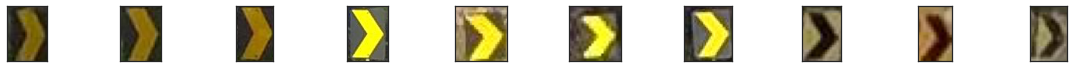

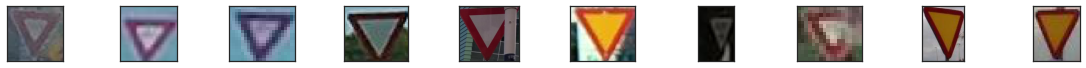

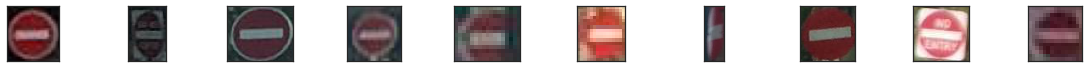

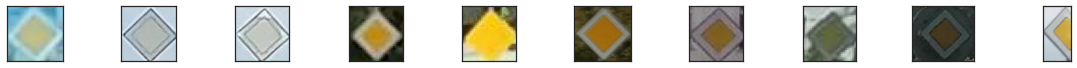

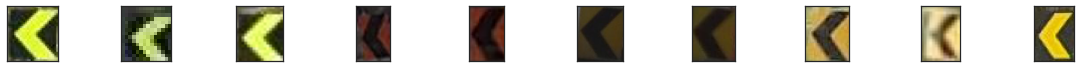

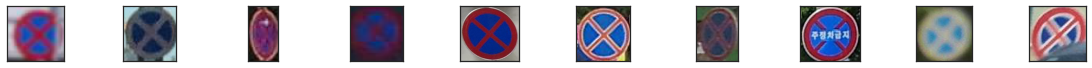

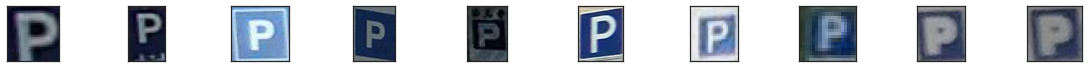

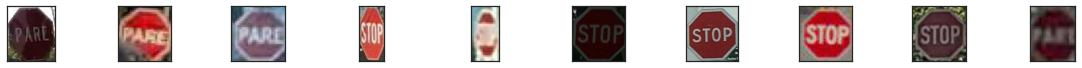

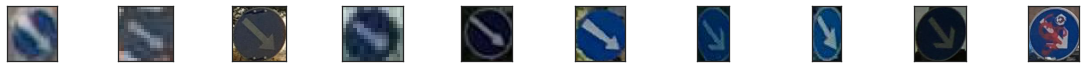

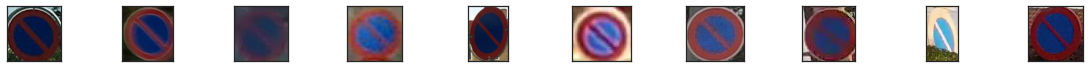

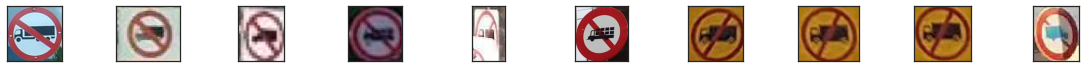

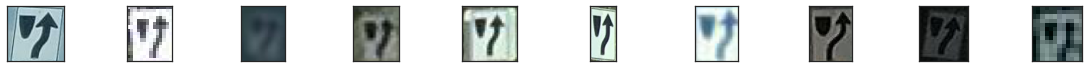

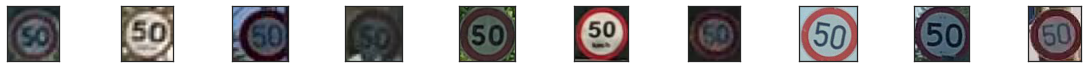

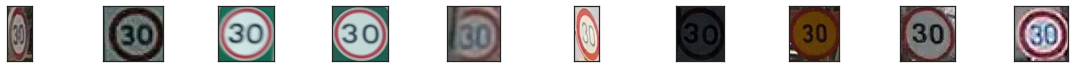

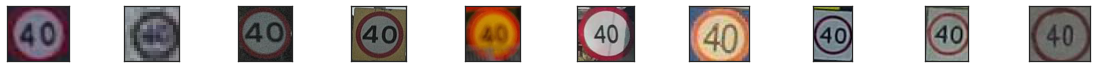

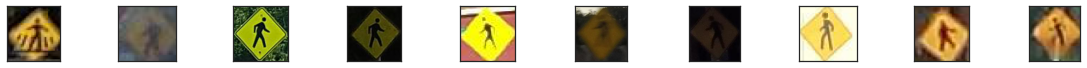

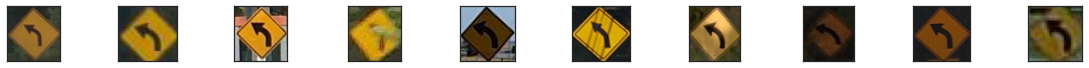

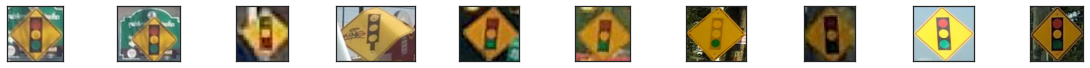

In [15]:
num_show = 10

for i in range(k):
    print(top_labels[i])
    idx_filter = np.nonzero([l == top_labels[i] for l in labels])
    lb_images = []
    for j in idx_filter[0][:num_show]:
        lb_images.append(images[j])
    show(lb_images, num_cols=num_show)

In [52]:
with open('/data/shared/mtsd_v2_fully_annotated/traffic_sign_dimension.csv', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if 'warning' in line and len(line.split(',')) == 2:
            lines[i] = line.replace('\n', ',diamond,36,36\n')
    
    for line in lines:
        assert len(line.split(',')) == 5

In [56]:
import pandas as pd 

data = pd.read_csv('/data/shared/mtsd_v2_fully_annotated/traffic_sign_dimension.csv') 
data

,label,id,shape,width,height
0,warning--added-lane-right--g1,w4-3,diamond,36.0,36.0
1,warning--bicycles-crossing--g2,w11-1,diamond,36.0,36.0
2,warning--bicycles-crossing--g3,NaN,diamond,36.0,36.0
3,warning--bus-stop-ahead--g3,NaN,diamond,36.0,36.0
4,warning--children--g2,NaN,diamond,36.0,36.0
...,...,...,...,...,...
101,regulatory--turn-left--g2,r3-5,rect,30.0,36.0
102,regulatory--turn-right--g3,r3-5,rect,30.0,36.0
103,regulatory--wrong-way--g1,r5-1a,rect,42.0,30.0
104,warning--school-zone--g2,s1-1,pentagon,36.0,36.0


- octagon,36,36
- diamond,36,36
- pentagon,36,36
- rect,36,48
- rect,30,36

In [62]:
selected_labels = ['octagon,36,36', 'diamond,36,36', 'pentagon,36,36', 'rect,36,48', 'rect,30,36']

grouped_labels = {}
with open('/data/shared/mtsd_v2_fully_annotated/traffic_sign_dimension.csv', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        for group, selected_label in enumerate(selected_labels):
            if selected_label in line:
                if group in grouped_labels:
                    grouped_labels[group].append(line.split(',')[0])
                else:
                    grouped_labels[group] = [line.split(',')[0]]
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(grouped_labels)

{   0: ['regulatory--stop--g1'],
    1: [   'warning--added-lane-right--g1',
           'warning--bicycles-crossing--g2',
           'warning--bicycles-crossing--g3',
           'warning--bus-stop-ahead--g3',
           'warning--children--g2',
           'warning--crossroads--g3',
           'warning--curve-left--g2',
           'warning--curve-right--g2',
           'warning--dip--g2',
           'warning--divided-highway-ends--g1',
           'warning--divided-highway-ends--g2',
           'warning--domestic-animals--g3',
           'warning--double-curve-first-left--g2',
           'warning--double-curve-first-right--g2',
           'warning--double-turn-first-right--g1',
           'warning--emergency-vehicles--g1',
           'warning--equestrians-crossing--g2',
           'warning--falling-rocks-or-debris-right--g2',
           'warning--falling-rocks-or-debris-right--g4',
           'warning--hairpin-curve-left--g1',
           'warning--height-restriction--g2',
           'war

In [70]:
mean_size = np.mean([max(img.shape) for img in images])
print(f'Sign mean size: {mean_size:.2f}')

mean_height = np.mean([img.shape[0] for img in images])
mean_width = np.mean([img.shape[1] for img in images])
print(f'Sign mean height/width: {mean_height:.2f}/{mean_width:.2f}')

mean_height = np.median([img.shape[0] for img in images])
mean_width = np.median([img.shape[1] for img in images])
print(f'Sign median height/width: {mean_height:.2f}/{mean_width:.2f}')

Sign mean size: 99.25
Sign mean height/width: 78.51/89.44
Sign median height/width: 55.00/58.00


## A2D2

- See https://www.a2d2.audi/a2d2/en/download.html and [paper](https://arxiv.org/pdf/2004.06320.pdf).
- Uses a broad group of `traffic sign` but has panoptic segmentation.
- Has labels for `traffic guide object` but the exact definition is unknown.
- License: Creative Commons Attribution-NoDerivatives 4.0 International License.

## ApolloScape

- See http://apolloscape.auto/scene.html and [paper](https://arxiv.org/pdf/1803.06184.pdf).
- Has `traffic sign` and `billboard` labels.
- Has both pixel-level and instance-level segmenation.
- 150K driving high-resolution images in China. 

---

# Others

## KITTI

- Too small: only has 200 training images and 200 testing images with segmentation.


## Waymo Perception

- Has 3D LiDAR labeling.
- Has 2D bounding boxes only for vehicles, pedestrians, cyclists.

## Canadian Adverse Driving Conditions Dataset

- http://cadcd.uwaterloo.ca/
- 3205 Traffic Guidance Objects

## Playing for Benchmarks

- Synthetic data from video games.
- https://vladlen.info/publications/playing-for-benchmarks/ and [paper](http://vladlen.info/papers/playing-for-benchmarks.pdf).

## nuImages

- Does not have labels for signs.

## PandaSet

- https://scale.com/open-datasets/pandaset#data-annotation
- 3D and LiDAR. Does not include signs.